In [ ]:
#Required Libraries
#pandas and numpy for handling data.
#request module for using FourSquare API.
#geopy to get co-ordinates of City of New York.
#folium to visualize the results on a map

In [13]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')


Libraries imported.


In [15]:
#We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres 
#for a given latitude and longitude. 
#Below function will return us the venue id , venue name and category.

In [16]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'RSBCJGPGPV4XY2CGIM315212REWGPCGCWTVJ51RSKTCG2KCV' # changed my Foursquare ID
    CLIENT_SECRET = 'BGEYGLLFUSUBOSCI5BGKWDIDJSX0Y0WADCEVA4OP5XQY2QBM' # changed Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

In [17]:
#Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [18]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'RSBCJGPGPV4XY2CGIM315212REWGPCGCWTVJ51RSKTCG2KCV' # changed my Foursquare ID
    CLIENT_SECRET = 'BGEYGLLFUSUBOSCI5BGKWDIDJSX0Y0WADCEVA4OP5XQY2QBM' # changed Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [19]:
#Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude

In [22]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [23]:
#We will call the above funtion to get the new york city data.

In [24]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [25]:
new_york_data.shape

(306, 4)

In [26]:
#So there are total of 306 different Neighborhoods in New York

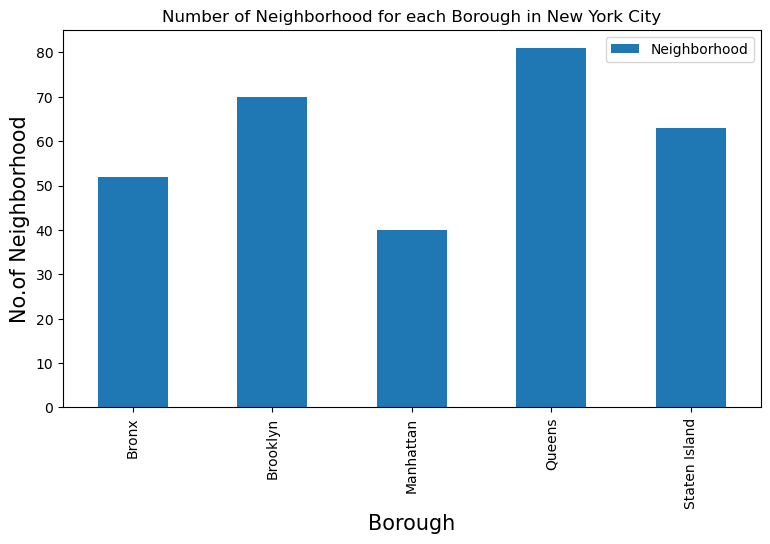

In [27]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


In [28]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
done
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
done
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
done
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
done
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
done
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
done
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
done
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
done
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
done
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
done
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
done
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
done
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
done
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
done
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
done
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
done
( 17 / 306 ) Indian Resturants in Ford

In [29]:
#Now that we have got all the indian resturants in new york city , we will analyze it

In [30]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [31]:
indian_rest_ny.shape

(151, 4)

In [32]:
#We got 151 Indian Resturants across New York City

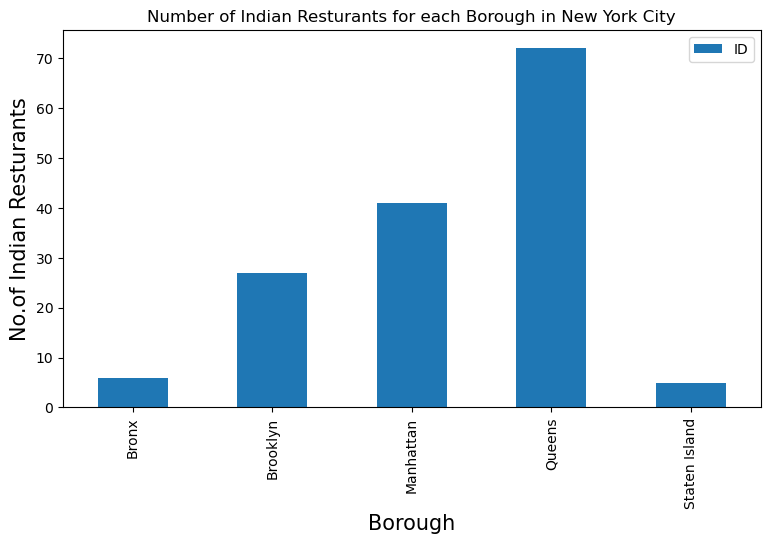

In [34]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [35]:
#We see that Queens has the largest number of indian resturants

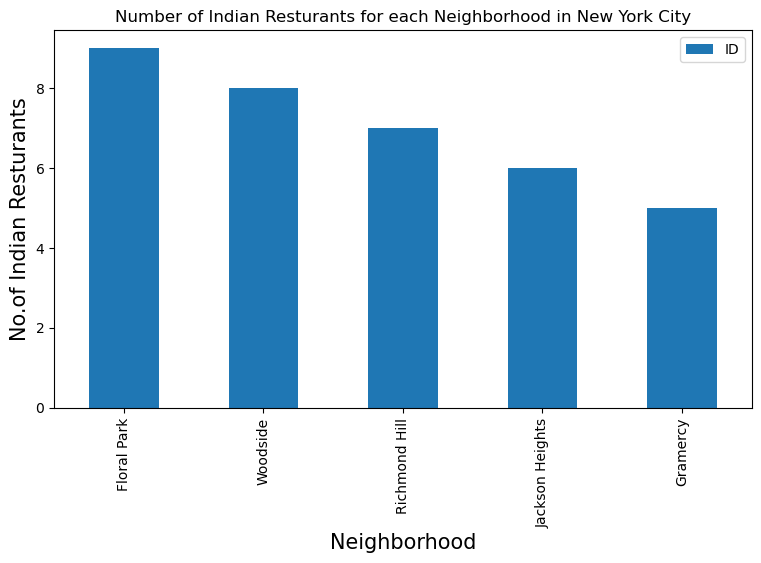

In [36]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [37]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
110,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
111,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
112,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
113,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
114,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
115,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
116,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
117,Queens,Floral Park,4cc642ed306e224b5bf2a76c,Shahi Darbar
118,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


In [38]:
#So Floral Park in Queens has the highest number of Indian Resturants with a total count of 9.

#Now we will get the ranking of each resturant for further analysis.

In [39]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.4    10
( 1 / 151 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 2 / 151 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.9     9
( 3 / 151 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.7     3
( 4 / 151 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 5 / 151 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     37     8.5    26
( 6 / 151 ) processed
                         ID          Name  Likes

KeyError: 'venue'

In [40]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.4,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [41]:
indian_rest_stats_ny.shape

(50, 7)

In [42]:
indian_rest_ny.shape

(151, 4)

In [43]:
#So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [44]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [45]:
#Lets verify the data from saved csv file

In [46]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [47]:
indian_rest_stats_ny_csv.shape

(50, 7)

In [48]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.4,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [49]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [50]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [51]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [52]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [53]:
#Now the data types looks correct

In [54]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                830
Rating                               8.7
Tips                                 255
Name: 41, dtype: object

In [55]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                830
Rating                               8.7
Tips                                 255
Name: 41, dtype: object

In [56]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [57]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
29,Tribeca,9.10
14,Greenwich Village,8.90
23,Prospect Heights,8.80
33,West Village,8.80
3,Chelsea,8.70
19,Midtown,8.65
9,East Village,8.60
20,North Side,8.50
27,South Side,8.50
11,Fort Greene,8.40


In [58]:
#Above are the top neighborhoods with top average rating of Indian resturant

In [59]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [60]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.213636
1,Brooklyn,7.813043
0,Bronx,6.400000


In [61]:
#Similarly these are the average rating of Indian Resturants for each Borough

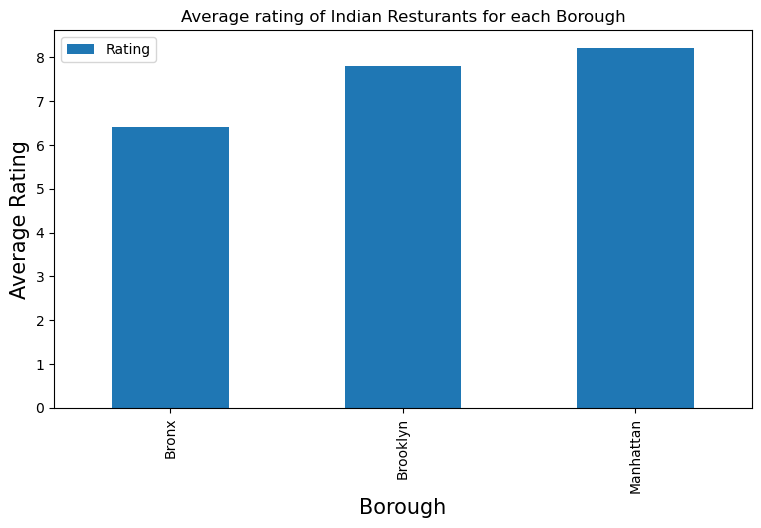

In [62]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


In [63]:
#We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [64]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [65]:
ny_neighborhood_stats

,Neighborhood,Average Rating
29,Tribeca,9.1


In [66]:
#We will join this dataset to original new york data to get lonitude and latitude

In [67]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [68]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [69]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Tribeca,40.721522,-74.010683,9.1


In [70]:
#Now we will show this data on a map

In [ ]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / 

In [ ]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [ ]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [ ]:
#Lets add a new field to dataframe for labeling purpose

In [ ]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [ ]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [ ]:
#Now that we have visualized the Neighborhoods. Lets Visualize Boroughs based on average Rating

In [ ]:
y_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')